<a href="https://colab.research.google.com/github/EduBrazGomes/ProjetoIntegrador/blob/main/Quest%C3%A3o9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Etapa 1: Configurar o ambiente e baixar o dataset de imagens

# 1. Instalar a biblioteca da API do Kaggle
!pip install kaggle

# 2. Fazer o upload do seu arquivo kaggle.json
#    Vá em sua conta no Kaggle -> Account -> API -> Create New API Token
#    Isso fará o download do arquivo. Faça o upload dele aqui.
print("\nPor favor, faça o upload do seu arquivo 'kaggle.json'")
from google.colab import files
files.upload()

# 3. Mover o arquivo para o diretório correto e definir permissões
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# 4. Baixar o dataset de Raio-X de Tórax do Kaggle
print("\nBaixando o dataset de Raio-X...")
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

# 5. Descompactar o dataset (o -q faz a extração sem listar todos os arquivos)
print("Descompactando as imagens...")
!unzip -q chest-xray-pneumonia.zip

print("\nAmbiente pronto e dataset descompactado!")


Por favor, faça o upload do seu arquivo 'kaggle.json'


Saving kaggle.json to kaggle.json

Baixando o dataset de Raio-X...
Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other
 99% 2.26G/2.29G [00:20<00:00, 38.1MB/s]
100% 2.29G/2.29G [00:20<00:00, 120MB/s] 
Descompactando as imagens...

Ambiente pronto e dataset descompactado!


--- Contagem de Imagens ---
Imagens de treino (NORMAL): 1341
Imagens de treino (PNEUMONIA): 3875
Imagens de teste (NORMAL): 234
Imagens de teste (PNEUMONIA): 390
------------------------------

--- Exemplos de Imagens ---


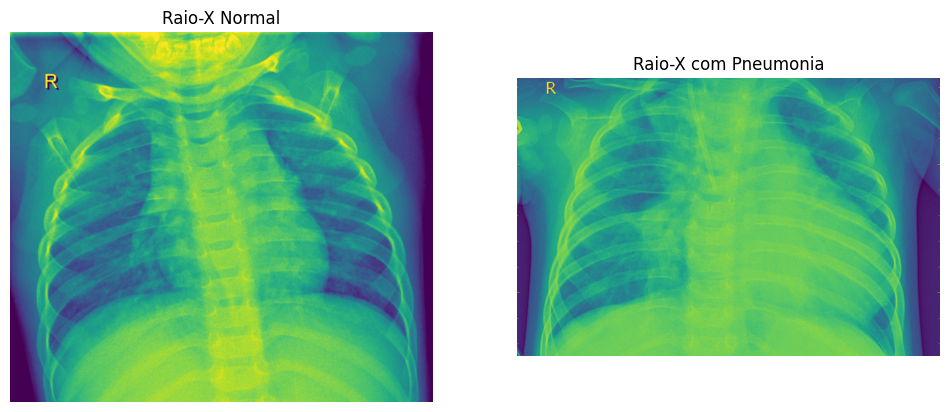


--- Configurando os Geradores de Dados ---
Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.

Geradores criados com sucesso!


In [ ]:
# Etapa 2: Explorando e Pré-processando os Dados

import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Definir os caminhos para os diretórios de dados
base_dir = 'chest_xray'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

# Caminhos para as subpastas de classes
train_normal_dir = os.path.join(train_dir, 'NORMAL')
train_pneumonia_dir = os.path.join(train_dir, 'PNEUMONIA')
test_normal_dir = os.path.join(test_dir, 'NORMAL')
test_pneumonia_dir = os.path.join(test_dir, 'PNEUMONIA')

# --- 1. Visualizar a contagem de imagens ---
print("--- Contagem de Imagens ---")
print('Imagens de treino (NORMAL):', len(os.listdir(train_normal_dir)))
print('Imagens de treino (PNEUMONIA):', len(os.listdir(train_pneumonia_dir)))
print('Imagens de teste (NORMAL):', len(os.listdir(test_normal_dir)))
print('Imagens de teste (PNEUMONIA):', len(os.listdir(test_pneumonia_dir)))
print("-" * 30)


# --- 2. Visualizar algumas imagens de exemplo ---
print("\n--- Exemplos de Imagens ---")
# Pega os nomes dos arquivos
normal_imgs = os.listdir(train_normal_dir)
pneumonia_imgs = os.listdir(train_pneumonia_dir)

# Plota 2 imagens normais e 2 com pneumonia
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(mpimg.imread(os.path.join(train_normal_dir, normal_imgs[5])))
axes[0].set_title('Raio-X Normal')
axes[0].axis('off')

axes[1].imshow(mpimg.imread(os.path.join(train_pneumonia_dir, pneumonia_imgs[5])))
axes[1].set_title('Raio-X com Pneumonia')
axes[1].axis('off')
plt.show()


# --- 3. Configurar Geradores de Imagens (ImageDataGenerator) ---
print("\n--- Configurando os Geradores de Dados ---")
# Criar gerador para os dados de treino com Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,          # Normaliza os pixels para o intervalo [0, 1]
    rotation_range=20,       # Rotaciona a imagem em até 20 graus
    width_shift_range=0.1,   # Desloca a largura em até 10%
    height_shift_range=0.1,  # Desloca a altura em até 10%
    shear_range=0.1,         # Aplica cisalhamento
    zoom_range=0.1,          # Aplica zoom de até 10%
    horizontal_flip=True,    # Inverte a imagem horizontalmente
    fill_mode='nearest'
)

# Criar gerador para os dados de validação e teste (apenas normalização)
# NUNCA use data augmentation nos dados de teste/validação!
validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Definir parâmetros
IMG_WIDTH, IMG_HEIGHT = 150, 150
BATCH_SIZE = 32

# Conectar os geradores aos diretórios de imagens
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='binary' # Problema de classificação binária
)

validation_generator = validation_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False # Importante para a avaliação
)

print("\nGeradores criados com sucesso!")

In [ ]:
# Etapa 3: Construindo o modelo de CNN

import tensorflow as tf

# Instanciando um modelo sequencial
model = tf.keras.models.Sequential([
    # 1ª Camada de Convolução e Pooling
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_WIDTH, IMG_HEIGHT, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),

    # 2ª Camada de Convolução e Pooling
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),

    # 3ª Camada de Convolução e Pooling
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),

    # 4ª Camada de Convolução e Pooling
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),

    # Camada para achatar os resultados para alimentar a camada Densa
    tf.keras.layers.Flatten(),

    # Camada de Dropout para regularização (evitar overfitting)
    tf.keras.layers.Dropout(0.5),

    # Camada Densa (totalmente conectada) com 512 neurônios
    tf.keras.layers.Dense(512, activation='relu'),

    # Camada de Saída com 1 neurônio e ativação sigmoid para classificação binária
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compilando o modelo
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Exibindo um resumo da arquitetura do modelo
print("--- Resumo da Arquitetura da CNN ---")
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


--- Resumo da Arquitetura da CNN ---


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 15, 15, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     3,211,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,453,121 (13.17 MB)

 Trainable params: 3,453,121 (13.17 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Etapa 4: Treinando o Modelo

# Definir o número de épocas (quantas vezes o modelo verá o dataset completo)
EPOCHS = 15

print("--- Iniciando o Treinamento da CNN ---")
print(f"O treinamento será executado por {EPOCHS} épocas. Isso pode levar vários minutos...")

# O método fit() inicia o treinamento
history = model.fit(
      train_generator,
      epochs=EPOCHS,
      validation_data=validation_generator,
      verbose=1
)

print("\n--- Treinamento Concluído! ---")

--- Iniciando o Treinamento da CNN ---
O treinamento será executado por 15 épocas. Isso pode levar vários minutos...


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 84s 452ms/step - accuracy: 0.7427 - loss: 0.5751 - val_accuracy: 0.6250 - val_loss: 0.7570
Epoch 2/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 72s 440ms/step - accuracy: 0.8715 - loss: 0.2947 - val_accuracy: 0.6250 - val_loss: 0.8824
Epoch 3/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 71s 437ms/step - accuracy: 0.9059 - loss: 0.2332 - val_accuracy: 0.7500 - val_loss: 0.7359
Epoch 4/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 71s 433ms/step - accuracy: 0.9104 - loss: 0.2049 - val_accuracy: 0.6250 - val_loss: 0.9057
Epoch 5/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 71s 436ms/step - accuracy: 0.9393 - loss: 0.1579 - val_accuracy: 0.6875 - val_loss: 0.7264
Epoch 6/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 71s 435ms/step - accuracy: 0.9248 - loss: 0.1963 - val_accuracy: 0.6250 - val_loss: 1.1649
Epoch 7/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 71s 435ms/step - accuracy: 0.9303 - loss: 0.1943 - val_accuracy: 0.5625 - val_loss: 1.4518
Epoch 8/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 70s 430ms/step - accuracy: 0.9372 - loss: 0

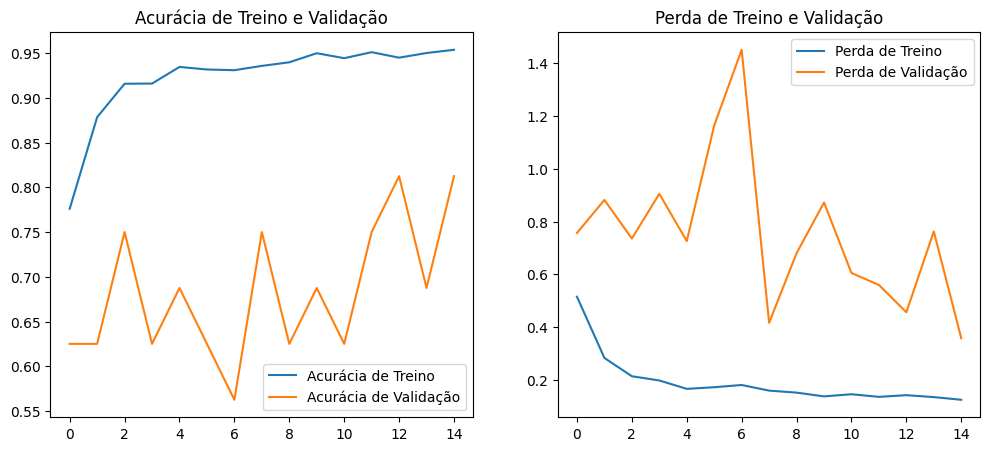


--- Avaliando o modelo no conjunto de teste ---
20/20 - 5s - 243ms/step - accuracy: 0.8526 - loss: 0.4336

Acurácia no conjunto de teste: 85.26%
20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 296ms/step

--- Relatório de Classificação ---
              precision    recall  f1-score   support

      NORMAL       0.94      0.65      0.77       234
   PNEUMONIA       0.82      0.97      0.89       390

    accuracy                           0.85       624
   macro avg       0.88      0.81      0.83       624
weighted avg       0.87      0.85      0.85       624



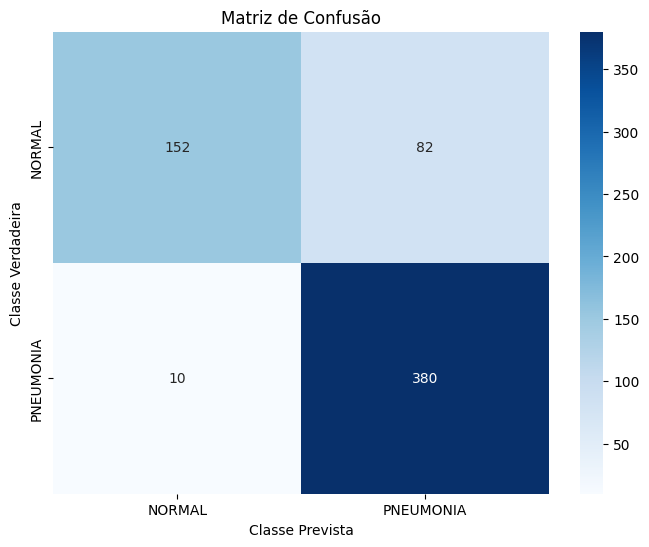

In [ ]:
# Etapa 5: Avaliação do Modelo

# --- 1. Visualizar o histórico de treinamento (Acurácia e Perda) ---
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Acurácia de Treino')
plt.plot(epochs_range, val_acc, label='Acurácia de Validação')
plt.legend(loc='lower right')
plt.title('Acurácia de Treino e Validação')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Perda de Treino')
plt.plot(epochs_range, val_loss, label='Perda de Validação')
plt.legend(loc='upper right')
plt.title('Perda de Treino e Validação')
plt.show()


# --- 2. Avaliar o modelo no conjunto de teste ---
print("\n--- Avaliando o modelo no conjunto de teste ---")
test_loss, test_acc = model.evaluate(test_generator, verbose=2)
print(f'\nAcurácia no conjunto de teste: {test_acc*100:.2f}%')


# --- 3. Gerar Matriz de Confusão e Relatório de Classificação ---
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Obter as previsões do modelo no conjunto de teste
predictions = model.predict(test_generator)
# Converter as probabilidades em classes (0 ou 1)
predicted_classes = (predictions > 0.5).astype(int).reshape(-1)

# Obter os rótulos verdadeiros
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Relatório de Classificação
print("\n--- Relatório de Classificação ---")
print(classification_report(true_classes, predicted_classes, target_names=class_labels))

# Matriz de Confusão
cm = confusion_matrix(true_classes, predicted_classes)

# Plotar a matriz de confusão
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Matriz de Confusão')
plt.ylabel('Classe Verdadeira')
plt.xlabel('Classe Prevista')
plt.show()